In [1]:
#подключение необходимых библиотек
import numpy as np
from matplotlib import  pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation
import time

In [2]:
#Возвращает значение полинома вида kind степени n в точке x
def polynomial (n, x, kind):
    #моном
    if (kind == 'monom'):
        return x**n
    #Полином Чебышева
    elif (kind == 'Chebyshev'):
        if(n == 0) :
            return 1
        elif (n == 1) :
            return x
        else:
            return 2*x*polynomial(n-1, x, kind) - polynomial(n -2, x, kind)
    #Полином Лежандра
    elif (kind == 'Legendre'):
        if (n == 0):
            return 1
        elif (n == 1):
            return x
        else:
            return (2*n -1) / n*x*polynomial(n-1, x, kind) - (n-1) / n * polynomial(n-2, x, kind)

#Функция составления матрицы A и вектора правой части b
def set_matrix (n, data, kind) :
    A = np.zeros((len(data), n+1))
    b = np.zeros(len(data))
    
    for i in range (len(data)) :
        for j in range (n+1):
            A[i][j] = polynomial(j, data[i][0], kind)
        b[i] = data [i][1]
    return A, b

#Функция аппроксимации данных с помощью QR алгоритма
def data_approximation_QR(n, data, kind) :
    start_time = time.time()

    A, b = set_matrix (n, data, kind)

    #todo Householder
    #QR разложение матрицы A
    Q, R = np.linalg.qr(A)

    #Выводим число обусловленности матрицы
    #print ('cond(A): ', np.linalg.cond(A))
    cond_value_R = np.linalg.cond(R)

    #Решение переопределенной СЛАУ QR методом
    coeffs = np.dot(np.linalg.inv(R), np.dot(Q.T, b))
    #Подсчет SME
    SME = np.sqrt(np.sum((np.dot(A, coeffs) - b)**2) / len(data)) / np.max(np.abs(b))
    #print ('SME: ', SME)
    
    f_approx = np.dot(A, coeffs)
    SME = np.sqrt(np.sum((f_approx - b)**2) / len(data)) / np.max(np.abs(b))
    
    end_time = time.time()
    computation_time = end_time - start_time
    return cond_value_R, SME, f_approx, coeffs, computation_time

#Функция аппроксимации данных методом НУ
def data_approximation_NU(n, data, type):
    start_time = time.time()
     
    A, b = set_matrix(n, data, type)
    #Формируем матрицу AtA и вектор Atb
    AtA = np.dot(A.T, A)
    np.savetxt("Ata.txt", AtA)
    Atb = np.dot(A.T, b)

    #Вычисляем число обусловленности матрицы
    cond_value_AtA = np.linalg.cond(AtA)
    
    #Выводим число обусловленности матрицы
    #print ('cond(AtA): ', cond_value)

    #Решение СЛАУ
    coeffs = np.linalg.solve(AtA, Atb)
    #Подсчет SME
    SME = np.sqrt(np.sum((np.dot(A, coeffs) - b)**2) / len(data)) / np.max(np.abs(b))
    #print ('SME: ', SME)

    f_approx = np.dot(A, coeffs)

    end_time = time.time()
    computation_time = end_time - start_time
    return cond_value_AtA, SME, f_approx, coeffs, computation_time
    #return np.dot(A, coeffs)


from matplotlib import  pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation

#функция для построения графиков: data - исходные данные (x, y), approximation_data - данные численного алгоритма (f(x), y)
def plot_graphics(data, approximation_data, n):
    fig = plt.figure(figsize=(12,8), frameon=True)
    plt.style.use('ggplot')
    #plt.rcParams["mathtext.fontset"] = "cm"
    #plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['font.size'] = 37
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    ax = fig.add_subplot(111)    

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.set(facecolor='w')
    ax.grid('axis = "both"', color = 'gray')

    ax.set_xlabel('$x$', labelpad = -10)
    ax.set_ylabel('$y$', rotation = 0, labelpad = 20)

    ax.plot(data[:,0], data[:,1], color = 'blue', linestyle = '-', linewidth = 3, label='Данные')
    #ax.plot(w_obr, P_obr, color = 'red', linestyle = '-', label = 'obrabotannoe')
    ax.plot(data[:,0], approximation_data, color = 'red', linestyle = '-', linewidth = 2, label = 'Приближение при N = ' + str(n))
    ax.legend(loc=4)

    plt.show()

In [3]:
# Функция для вычисления значения полинома в точке x
def eval_polynomial(coeffs, x):
    result = 0
    for i, c in enumerate(coeffs):
        result += c * (x ** i)
    return result

In [12]:
#Пример вызова функции аппроксимации данных
File_name = 'data/data_1.txt'
data = np.loadtxt(File_name, dtype = float)
#Степень полинома
max_n = 10


#запись всех данных в файл, чтобы оттуда записать в таблицу =(
# Открываем файл для записи результатов
filename_comparison = 'comparison_simple1.txt'
with open(filename_comparison, 'w', encoding='utf-8') as f:
    
    f.write("СРАВНЕНИЕ МЕТОДОВ АППРОКСИМАЦИИ\n")
    f.write("Файл данных: " + File_name + "\n")
    f.write("Максимальная степень полинома: " + str(max_n ) + "\n\n")
    
    tab = "\t"
    f.write("МЕТОД НОРМАЛЬНЫХ УРАВНЕНИЙ (НУ):\n")
    f.write(f"max_n{tab}cond_value_AtA{tab}SME{tab}comp_time сек \n")
       
    for max_n  in range(max_n  + 1):
        try:
            cond_value_AtA, SME, f_approx, coeffs, comp_time = data_approximation_NU(max_n , data, 'monom')
            f.write(f"{max_n }{tab}{cond_value_AtA:.6e}{tab}{SME:.6e}{tab}{comp_time:.6f}\n")
        except np.linalg.LinAlgError:
            f.write(f"n={max_n }: Ошибка - вырожденная матрица\n")
    
    f.write("\nМЕТОД QR-РАЗЛОЖЕНИЯ:\n")
    f.write(f"max_n{tab}cond_value_R{tab}SME{tab}comp_time сек \n")
    for max_n  in range(max_n  + 1):
        try:
            cond_value_R, SME_qr, f_approx, coeffs, comp_time = data_approximation_QR(max_n , data, 'monom')
            f.write(f"{max_n }{tab}{cond_value_R:.6e}{tab}{SME_qr:.6e}{tab}{comp_time:.6f}\n")
        except np.linalg.LinAlgError:
            f.write(f"n={max_n }: Ошибка - вырожденная матрица\n")
    
    # Простое сравнение методов
    f.write("\nСРАВНЕНИЕ МЕТОДОВ:\n")
    
    # Собираем данные для сравнения
    nu_results = []
    qr_results = []
    
    for max_n  in range(max_n  + 1):
        try:
            cond_nu, sme_nu, _, _, time_nu = data_approximation_NU(max_n , data, 'monom')
            nu_results.append((max_n , cond_nu, sme_nu, time_nu))
        except:
            nu_results.append((max_n , None, None, None))
            
        try:
            cond_qr, sme_qr, _, _, time_qr = data_approximation_QR(max_n , data, 'monom')
            qr_results.append((max_n , cond_qr, sme_qr, time_qr))
        except:
            qr_results.append((max_n , None, None, None))
    
    # Находим лучшие результаты
    valid_nu = [r for r in nu_results if r[2] is not None]
    valid_qr = [r for r in qr_results if r[2] is not None]
    
    if valid_nu:
        best_nu = min(valid_nu, key=lambda x: x[2])  # минимальная SME
        f.write(f"Лучший результат НУ: n={best_nu[0]}, SME={best_nu[2]:.6e}\n")
    
    if valid_qr:
        best_qr = min(valid_qr, key=lambda x: x[2])  # минимальная SME
        f.write(f"Лучший результат QR: n={best_qr[0]}, SME={best_qr[2]:.6e}\n")
    
    # Сравнение времени
    times_nu = [r[3] for r in valid_nu if r[3] is not None]
    times_qr = [r[3] for r in valid_qr if r[3] is not None]
    
    if times_nu and times_qr:
        avg_time_nu = sum(times_nu) / len(times_nu)
        avg_time_qr = sum(times_qr) / len(times_qr)
        f.write(f"Среднее время НУ: {avg_time_nu:.6f} сек\n")
        f.write(f"Среднее время QR: {avg_time_qr:.6f} сек\n")

print(f"Результаты сохранены в файл: {filename_comparison}")




Результаты сохранены в файл: comparison_simple1.txt


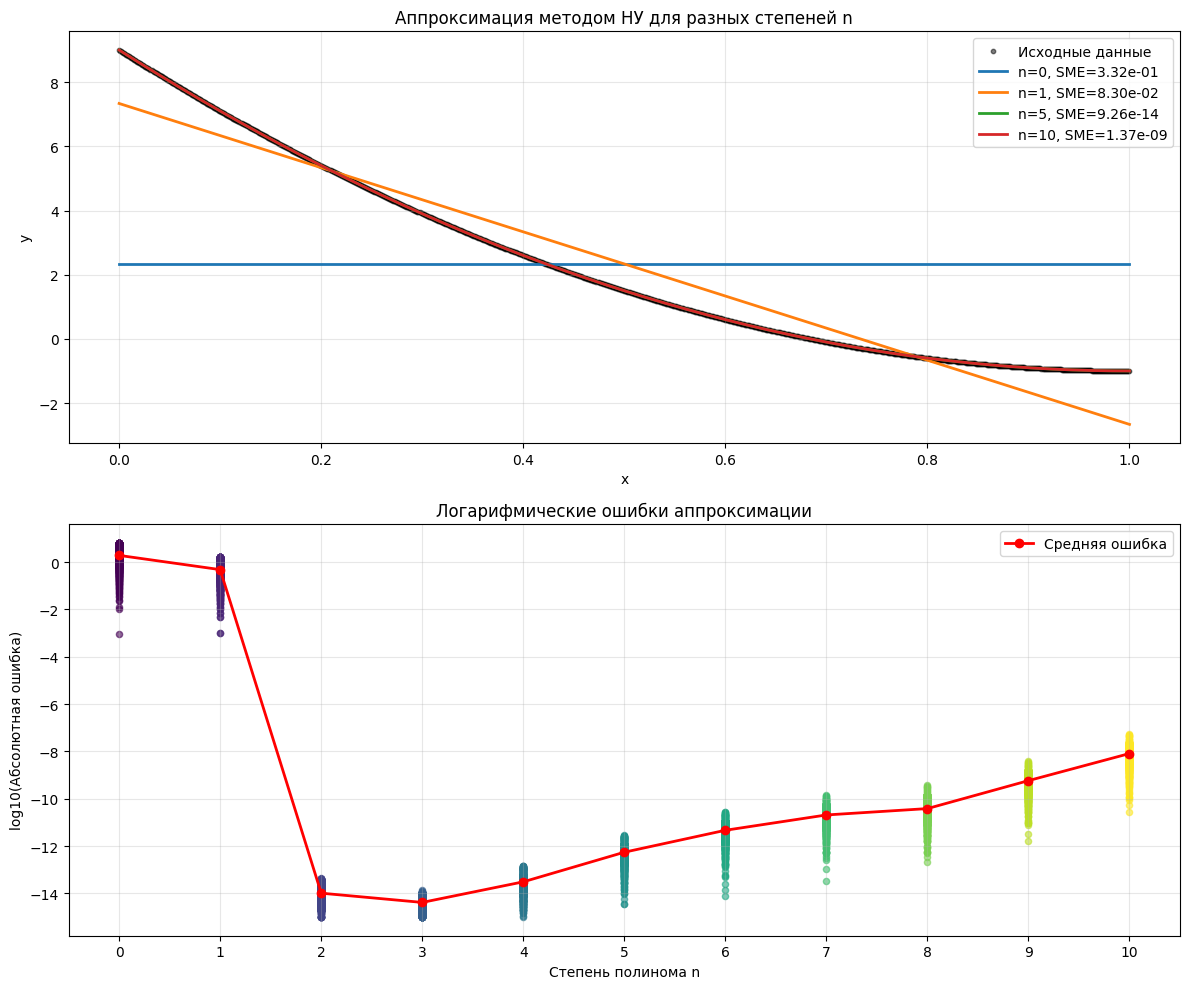

График сохранен в файл: approximation_plot.png


In [ ]:
File_name = 'data/data_5.txt'
data = np.loadtxt(File_name, dtype = float)
x_data = data[:, 0]
y_data = data[:, 1]
max_n = 10 #Степень полинома\n",

# Создаем фигуру с двумя subplots
plt.figure(figsize=(12, 10))

# ГРАФИК 1: Данные и аппроксимация для выбранных значений n (верхний график)
plt.subplot(2, 1, 1)  # 2 строки, 1 столбец, позиция 1
# Отображаем исходные данные
plt.scatter(x_data, y_data, color='black', label='Исходные данные', alpha=0.5, s=10)

# Выбираем несколько значений n для отображения
selected_n = [0,1,5,10]   # Можно изменить на нужные степени

# Создаем плотную сетку для гладких графиков аппроксимации
x_smooth = np.linspace(np.min(x_data), np.max(x_data), 300)

for n in selected_n:
    try:
        cond_value_AtA, SME, f_approx, coeffs, comp_time = data_approximation_NU(n, data, 'monom')
        
        # Вычисляем значения полинома на плотной сетке
        y_smooth = [eval_polynomial(coeffs, x) for x in x_smooth]
        
        plt.plot(x_smooth, y_smooth, linewidth=2, label=f'n={n}, SME={SME:.2e}')
        
    except np.linalg.LinAlgError:
        print(f"Ошибка для n={n}")

plt.xlabel('x')
plt.ylabel('y')
plt.title('Аппроксимация методом НУ для разных степеней n')
plt.legend()
plt.grid(True, alpha=0.3)

# ГРАФИК 2: Ошибки аппроксимации в логарифмической шкале (нижний график)
plt.subplot(2, 1, 2)  # 2 строки, 1 столбец, позиция 2

n_values = []
errors = []
colors = plt.cm.viridis(np.linspace(0, 1, max_n + 1))

for n in range(max_n + 1):
    try:
        cond_value_AtA, SME, f_approx, coeffs, comp_time = data_approximation_NU(n, data, 'monom')
        
        # Вычисляем абсолютные ошибки в точках данных
        absolute_errors = np.abs(f_approx - y_data)
        log_errors = np.log10(absolute_errors + 1e-15)  # +1e-15 чтобы избежать log(0)
        
        plt.scatter([n] * len(log_errors), log_errors, color=colors[n], alpha=0.6, s=20)
        
        # Средняя ошибка
        mean_log_error = np.mean(log_errors)
        n_values.append(n)
        errors.append(mean_log_error)
        
    except np.linalg.LinAlgError:
        print(f"Ошибка для n={n}")

# Соединяем средние значения ошибок
if n_values:
    plt.plot(n_values, errors, 'r-', linewidth=2, marker='o', markersize=6, label='Средняя ошибка')

plt.xlabel('Степень полинома n')
plt.ylabel('log10(Абсолютная ошибка)')
plt.title('Логарифмические ошибки аппроксимации')
plt.xticks(range(0, max_n + 1))
plt.grid(True, alpha=0.3)
plt.legend()

# Настраиваем layout и сохраняем
plt.tight_layout()
plt.savefig('approximation_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("График сохранен в файл: approximation_plot.png")
